In [1]:
options(warn = -1)

In [ ]:
packages <- c("readr", "dplyr", "tidyr", "ggplot2", "scales", "stringr", "svglite")

installed <- packages %in% rownames(installed.packages())
if (any(!installed)) {
  install.packages(packages[!installed])
}

lapply(packages, library, character.only = TRUE)

Sys.setlocale("LC_CTYPE", "en_US.UTF-8")

In [3]:
read_eurostat_tsv <- function(path, pyear, presid) {
  df <- read_tsv(path, na = ":", trim_ws = TRUE)
  
  first_col <- colnames(df)[1]
  n_parts <- max(str_count(df[[1]], ",") + 1) 
  
  split_names <- c('freq','unit','sex','age','icd10','resid','geo')
  
  df <- df %>%
    separate(col = 1, into = split_names, sep = ",", remove = TRUE) %>%
    pivot_longer(
      cols = -all_of(split_names),
      names_to = "year",
      values_to = "deaths"
    ) %>% mutate(year = as.integer(year)) %>% 
    filter(year == pyear, sex %in% c('F', 'M')) %>%
    filter(geo == 'EU27_2020', resid == presid) %>%
    select(-1, -2) %>% filter(icd10 %in% c('I', 'TOTAL')) %>%
    filter(age %in% c("TOTAL", "Y1-4", "Y5-9", "Y10-14", "Y15-29", "Y30-44", "Y45-64", "Y65-69", "Y70-74", "Y75-79", "Y80-84", "Y85-89", "Y90-94"))
  
  df
}

In [4]:
source <- "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/hlth_cd_aro?format=TSV&compressed=true"

In [5]:
con <- gzcon(url(source, "rb"))

In [6]:
year_to_analyze = 2022

In [7]:
df <- read_eurostat_tsv(con, year_to_analyze, 'TOT_RESID') %>% pivot_wider(id_cols = c(icd10, sex), names_from = age, values_from = deaths) %>% 
  mutate(across(all_of(c("TOTAL", "Y1-4", "Y5-9", "Y10-14", "Y15-29", "Y30-44", "Y45-64", "Y65-69", "Y70-74", "Y75-79", "Y80-84", "Y85-89", "Y90-94")), as.integer)) %>%
  mutate(age_below_45 = rowSums(across(all_of(c("Y1-4", "Y5-9", "Y10-14", "Y15-29", "Y30-44"))), na.rm = TRUE), 
         age_45_79 = rowSums(across(all_of(c("Y45-64", "Y65-69", "Y70-74", "Y75-79"))), na.rm = TRUE),
         age_above_80 = TOTAL - age_below_45 - age_45_79, 
         age_above_80l = rowSums(across(all_of(c("Y80-84", "Y85-89", "Y90-94"))), na.rm = TRUE),
         Y95plus = age_above_80 - age_above_80l) %>%
  pivot_longer(cols = -c(icd10, sex), names_to = "age_group", values_to = "deaths") %>%
  pivot_wider(id_cols = c(sex, age_group), names_from = "icd10", values_from = "deaths") %>%
  mutate(ratio = I / TOTAL * 100) %>%
  pivot_longer(cols = -c(age_group, sex), names_to = "icd10", values_to = "deaths") %>%
  filter(icd10 != 'TOTAL', age_group %in% c("Y30-44", "Y45-64", "Y65-69", "Y70-74", "Y75-79", "Y80-84", "Y85-89", "Y90-94", "Y95plus")) %>%
  pivot_wider(id_cols = c(age_group, sex), names_from = icd10, values_from = deaths) %>%
  mutate(age_group = recode(age_group,
                            "Y30-44" = "30–44", "Y45-64" = "45–64", "Y65-69" = "65–69", "Y70-74" = "70–74", 
                            "Y75-79" = "75–79", "Y80-84" = "80–84", "Y85-89" = "85–89", "Y90-94" = "90–94", 
                            "Y95plus" = "95+"),
         sex = recode(sex, "F" = "female", "M" = "male"))

Rows: 672804 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (14): freq,unit,sex,age,icd10,resid,geo\TIME_PERIOD, 2011, 2012, 2013, 2...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Saving 7 x 7 in image


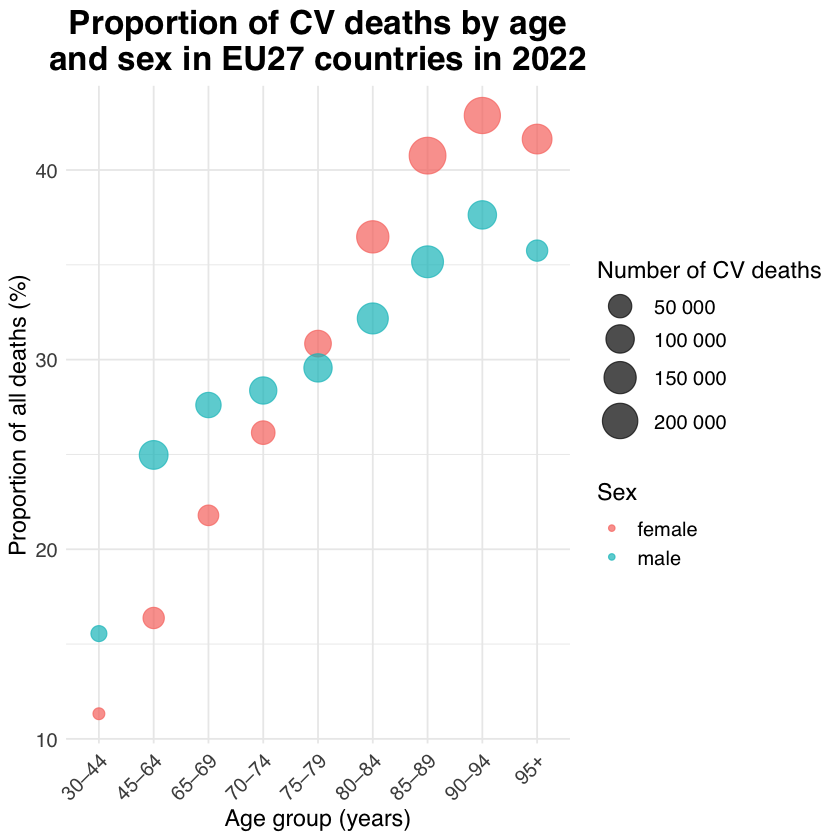

In [8]:
ggplot(df, aes(x = age_group, y = ratio, color = sex, size = I)) +
  geom_point(alpha = 0.7) +
  scale_size_continuous(range = c(3, 10), labels = label_number(big.mark = " ")) +
  labs(
    x = "Age group (years)",
    y = "Proportion of all deaths (%)",
    size = "Number of CV deaths",
    color = "Sex"
  ) +
  ggtitle(paste("Proportion of CV deaths by age\nand sex in EU27 countries in", year_to_analyze)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12),
        axis.text.y = element_text(size = 12, family = "Helvetica"),
        axis.title.x = element_text(size = 14, family = "Helvetica"),
        axis.title.y = element_text(size = 14, family = "Helvetica"),
        legend.title = element_text(size = 14, family = "Helvetica"),
        legend.text = element_text(size = 12, family = "Helvetica"),
        plot.title = element_text(hjust = 0.5, size = 20, face = "bold", family = "Helvetica"))

ggsave("plot.svg", plot = last_plot())